Notebook purpose

- Sense-check and explore calculated account balances

In [1]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append('/Users/fgu/dev/projects/entropy')
import entropy.helpers.aws as aws
import entropy.data.cleaners as cl
import entropy.data.creators as cr

sns.set_style('whitegrid')
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)
pd.set_option('max_colwidth', None)
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

In [2]:
SAMPLE = 'X77'
fp = f'~/tmp/entropy_{SAMPLE}.parquet'

df = aws.read_parquet(fp)
print('Rows: {:,.0f}\nUsers: {}'.format(df.shape[0], df.user_id.nunique()))
df.head(1)

Rows: 1,275,582
Users: 431


,id,date,user_id,amount,desc,merchant,tag_group,tag,user_female,user_postcode,user_registration_date,user_salary_range,user_yob,account_created,account_id,account_last_refreshed,account_provider,account_type,data_warehouse_date_created,data_warehouse_date_last_updated,debit,desc_old,latest_balance,merchant_business_line,tag_auto,tag_manual,tag_up,updated_flag,ym,balance,income,savings
0,688261,2012-01-03,777,400.0,mdbremoved,NaN,transfers,transfers,False,wa1 4,2011-07-20,20k to 30k,1969.0,2011-07-20,262916,2020-07-21 20:32:00,natwest bank,current,2014-07-18,2017-11-13,True,<mdbremoved> - s/o,364.220001,non merchant mbl,transfers,other account,other account,u,201201,-1542.99646,24319.220881,False


## Balances over time

Below shows median of median weekly balances.

In [3]:
def median_balance(df, account_type='current', freq='w'):
    """Calculate median balance account type."""
    return (df.loc[df.account_type == account_type]
            .set_index('date')
            .sort_index()
            .loc['2013':]
            .groupby(['user_id', 'account_id'])
            .resample('d').balance.first()
            .groupby(['user_id', 'date']).sum(min_count=1)
            .groupby('date').median()
            .resample(freq).median())

In [4]:
current_account_balances = median_balance(df, account_type='current', freq='w')
savings_account_balances = median_balance(df, account_type='savings', freq='w')
credit_card_balances = median_balance(df, account_type='credit card', freq='w')
users = df.resample('w', on='date').user_id.nunique()

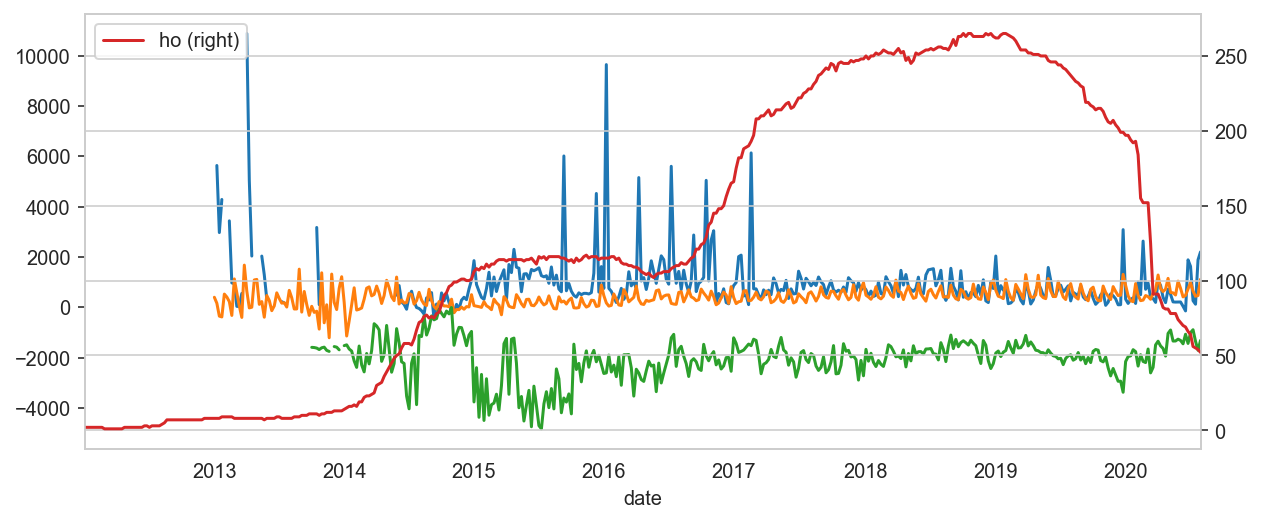

In [6]:
plotargs = dict(figsize = (10, 4))
savings_account_balances.plot(**plotargs, label='savings')
current_account_balances.plot(**plotargs, label='current')
credit_card_balances.plot(**plotargs, label='credit')
users.plot(**plotargs, secondary_y=True, label='ho')
plt.legend();

## Monthly current-account balance pattern

2018 data for monthly pattern

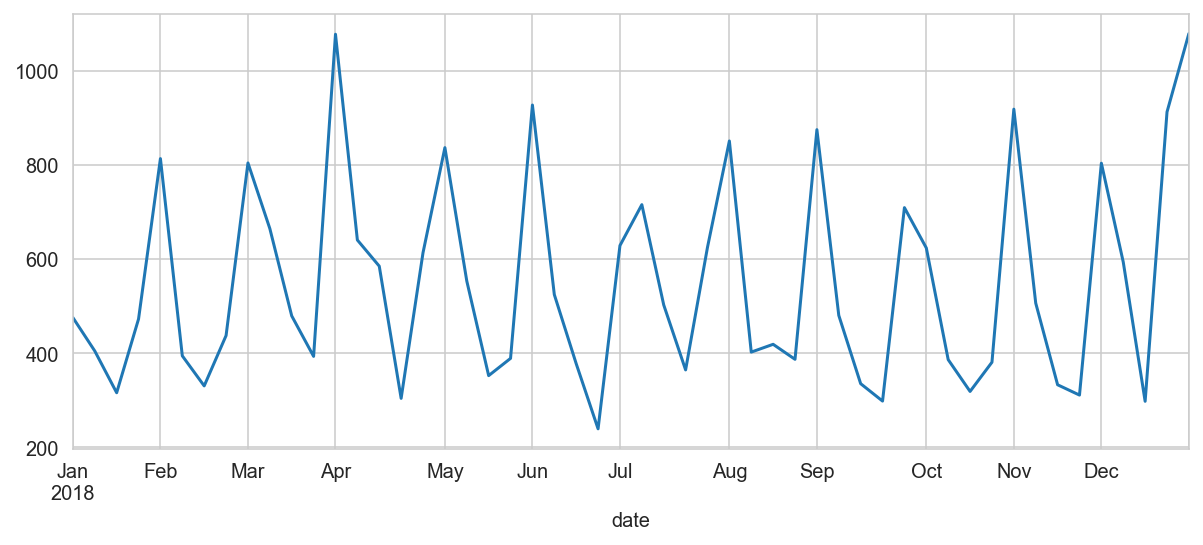

In [8]:
current_account_balances.loc['2018'].plot(**plotargs);

As expected, balances are high around salary payment dates and then decline throughout the month

## Income-scaled balances

Plot weekly median (across weekdays) of daily median current account balance divided by monthly income (across users).

In [9]:
daily_balance = (df.loc[df.account_type == 'current']
            .set_index('date')
            .sort_index()
            .loc['2013':]
            .groupby(['user_id', 'account_id'])
            .resample('d').balance.first()
            .groupby(['user_id', 'date']).sum(min_count=1))

monthly_income = (df.set_index('date')
                  .groupby('user_id')
                  .resample('d').income.first()
                  .div(12))

scaled_balance = (daily_balance
                  .div(monthly_income)
                  .rename('scaled_balance'))

weekly_agg_scaled_balance = (scaled_balance
                             .resample('d', level='date').median()
                             .resample('w').median())

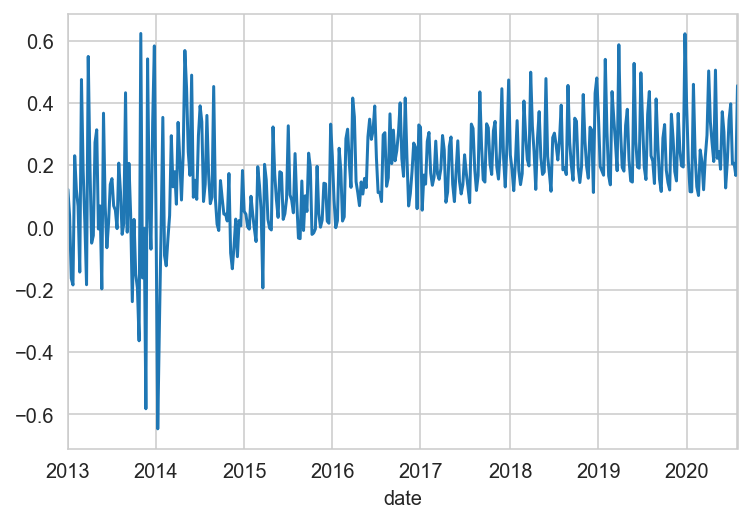

In [10]:
weekly_agg_scaled_balance.loc['2013':].plot();

Monthly pattern in 2018

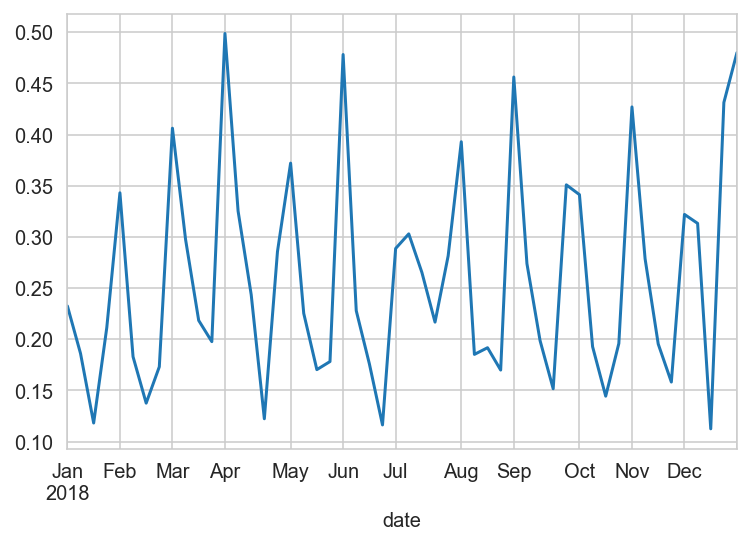

In [11]:
weekly_agg_scaled_balance.loc['2018'].plot();

### Identify overdraft fee txns

What are common transaction descriptions for tags that likely contain od fee txns?

In [70]:
tags = ['bank charges', 'banking charges', 'penalty charges']
df[df.tag_auto.isin(tags)].desc.str[:20].value_counts()[:5]

daily od fee chg        4980
daily od fee            4841
non sterling transac    2602
account fee              927
non stg trans fee 2      905
Name: desc, dtype: int64

What are descriptions for descs with od fees?

In [64]:
pattern = r'\b(od|o d|overdraft|o draft)\b.*(fee|usage|interest)'
mask = df.desc.str.contains(pattern) & df.debit
df[mask].tag_auto.value_counts()[:9]

/var/folders/xg/n9p73cf50s52twlnz7z778vr0000gn/T/ipykernel_2024/1203112464.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  mask = df.desc.str.contains(pattern) & df.debit


bank charges                    16681
interest charges                  777
banking charges                   373
interest income                   173
accessories                         0
pet - everyday or food              0
payday loan                         0
payday loan funds                   0
payment protection insurance        0
Name: tag_auto, dtype: int64

Precision of above mask is very high

In [69]:
df[mask].desc.sample(n=10)

907390                            daily od fee chg
1118719           arranged od usage 16aug a c 7031
1263434                           o draft interest
1130525                               daily od fee
1248920                               daily od fee
71507                                o d usage fee
255909                            daily od fee chg
1159795                               daily od fee
36066      arranged od usage 22aug a c 6760 charge
433574                            daily od fee chg
Name: desc, dtype: object

Use the following mask to identify od fee txns:

Addition of word boundaries for first group and omission for second group is based on inspection -- there are strings where interest is not a stand-alone word (often *interestto*).

In [71]:
pattern = r'\b(od|o d|overdraft|o draft)\b.*(fee|usage|interest)'
mask = df.desc.str.contains(pattern) & df.debit

/var/folders/xg/n9p73cf50s52twlnz7z778vr0000gn/T/ipykernel_2024/2712487853.py:2: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  mask = df.desc.str.contains(pattern) & df.debit


## Case studies

### Users

In [3]:
SAMPLE_SIZE = df.user_id.nunique()
SAMPLE_SIZE = 2

rng = np.random.default_rng(seed=2312)
user_sample = rng.choice(df.user_id.unique(), size=SAMPLE_SIZE)
mask = df.user_id.isin(user_sample)

daily_balances = (df[mask]
                  .set_index('date')
                  .assign(account_label=lambda x: x.account_type.astype('str') + '-' + x.account_id.astype('str'))
                  .groupby(['account_label', 'user_id'])
                  .resample('D').balance.first()
                  .fillna(method='ffill')
                  .reset_index()
                  .sort_values('user_id'))

daily_balances.head(2)

,account_label,user_id,date,balance
0,current-278242,84777,2014-04-04,839.7099
305,current-278244,84777,2014-08-23,430.0000


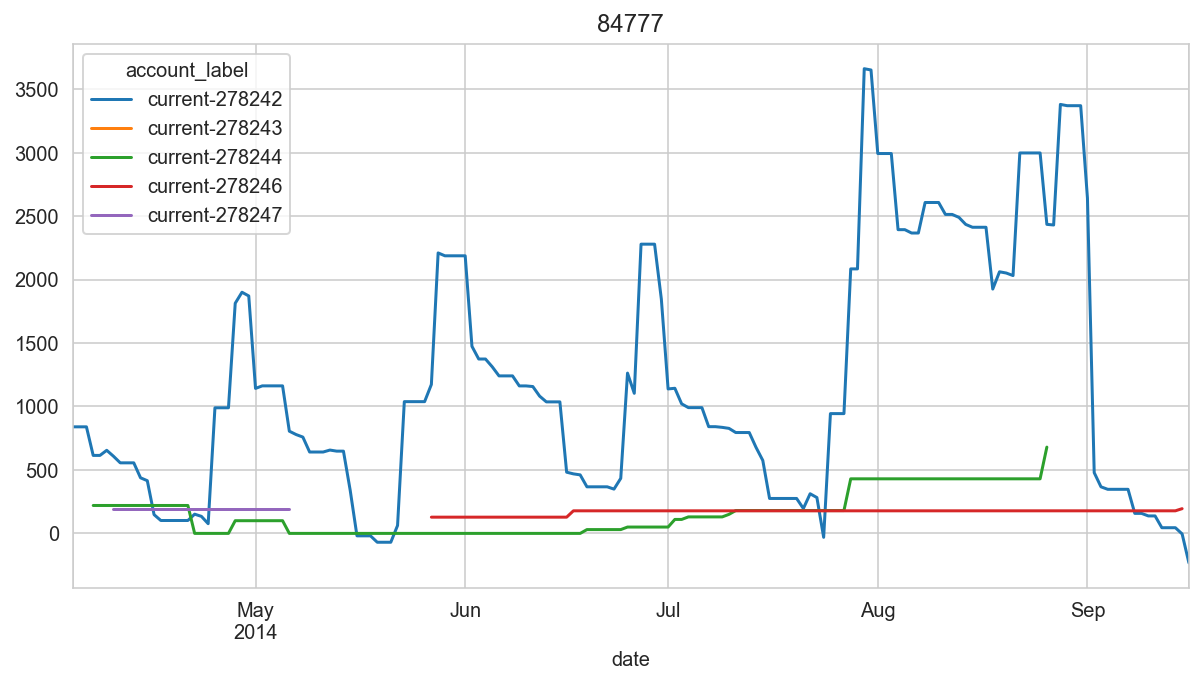

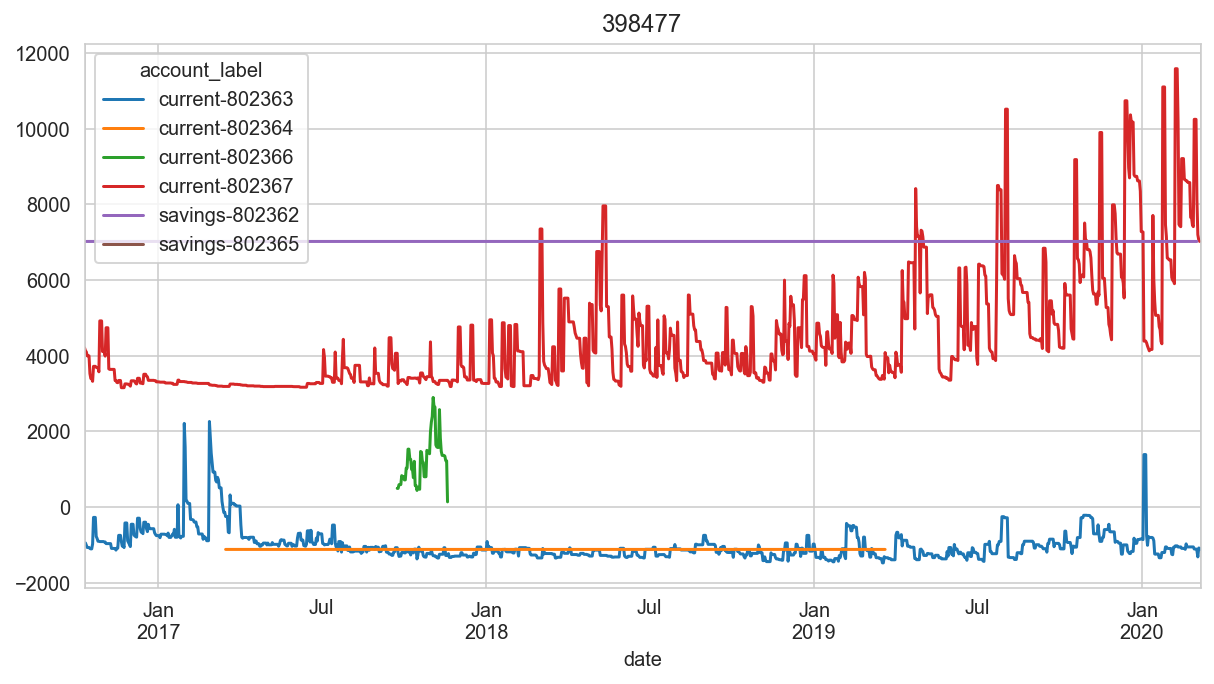

In [4]:
for id, data in daily_balances.groupby('user_id'):
    pivot = data.pivot_table('balance', 'date', 'account_label')
    if not pivot.empty:
        pivot.plot(figsize=(10, 5), title=id);

### Savings accouns

In [7]:
savings_balances = (df[df.account_type == 'savings']
                    .assign(account_label=lambda x: 
                            x.account_id.astype('str') + '-' 
                            + x.user_id.astype('str'))
                    .set_index('date')
                    .groupby(['account_label'])
                    .resample('D').balance.first()
                    .fillna(method='ffill')
                    .dropna()
                    .reset_index())

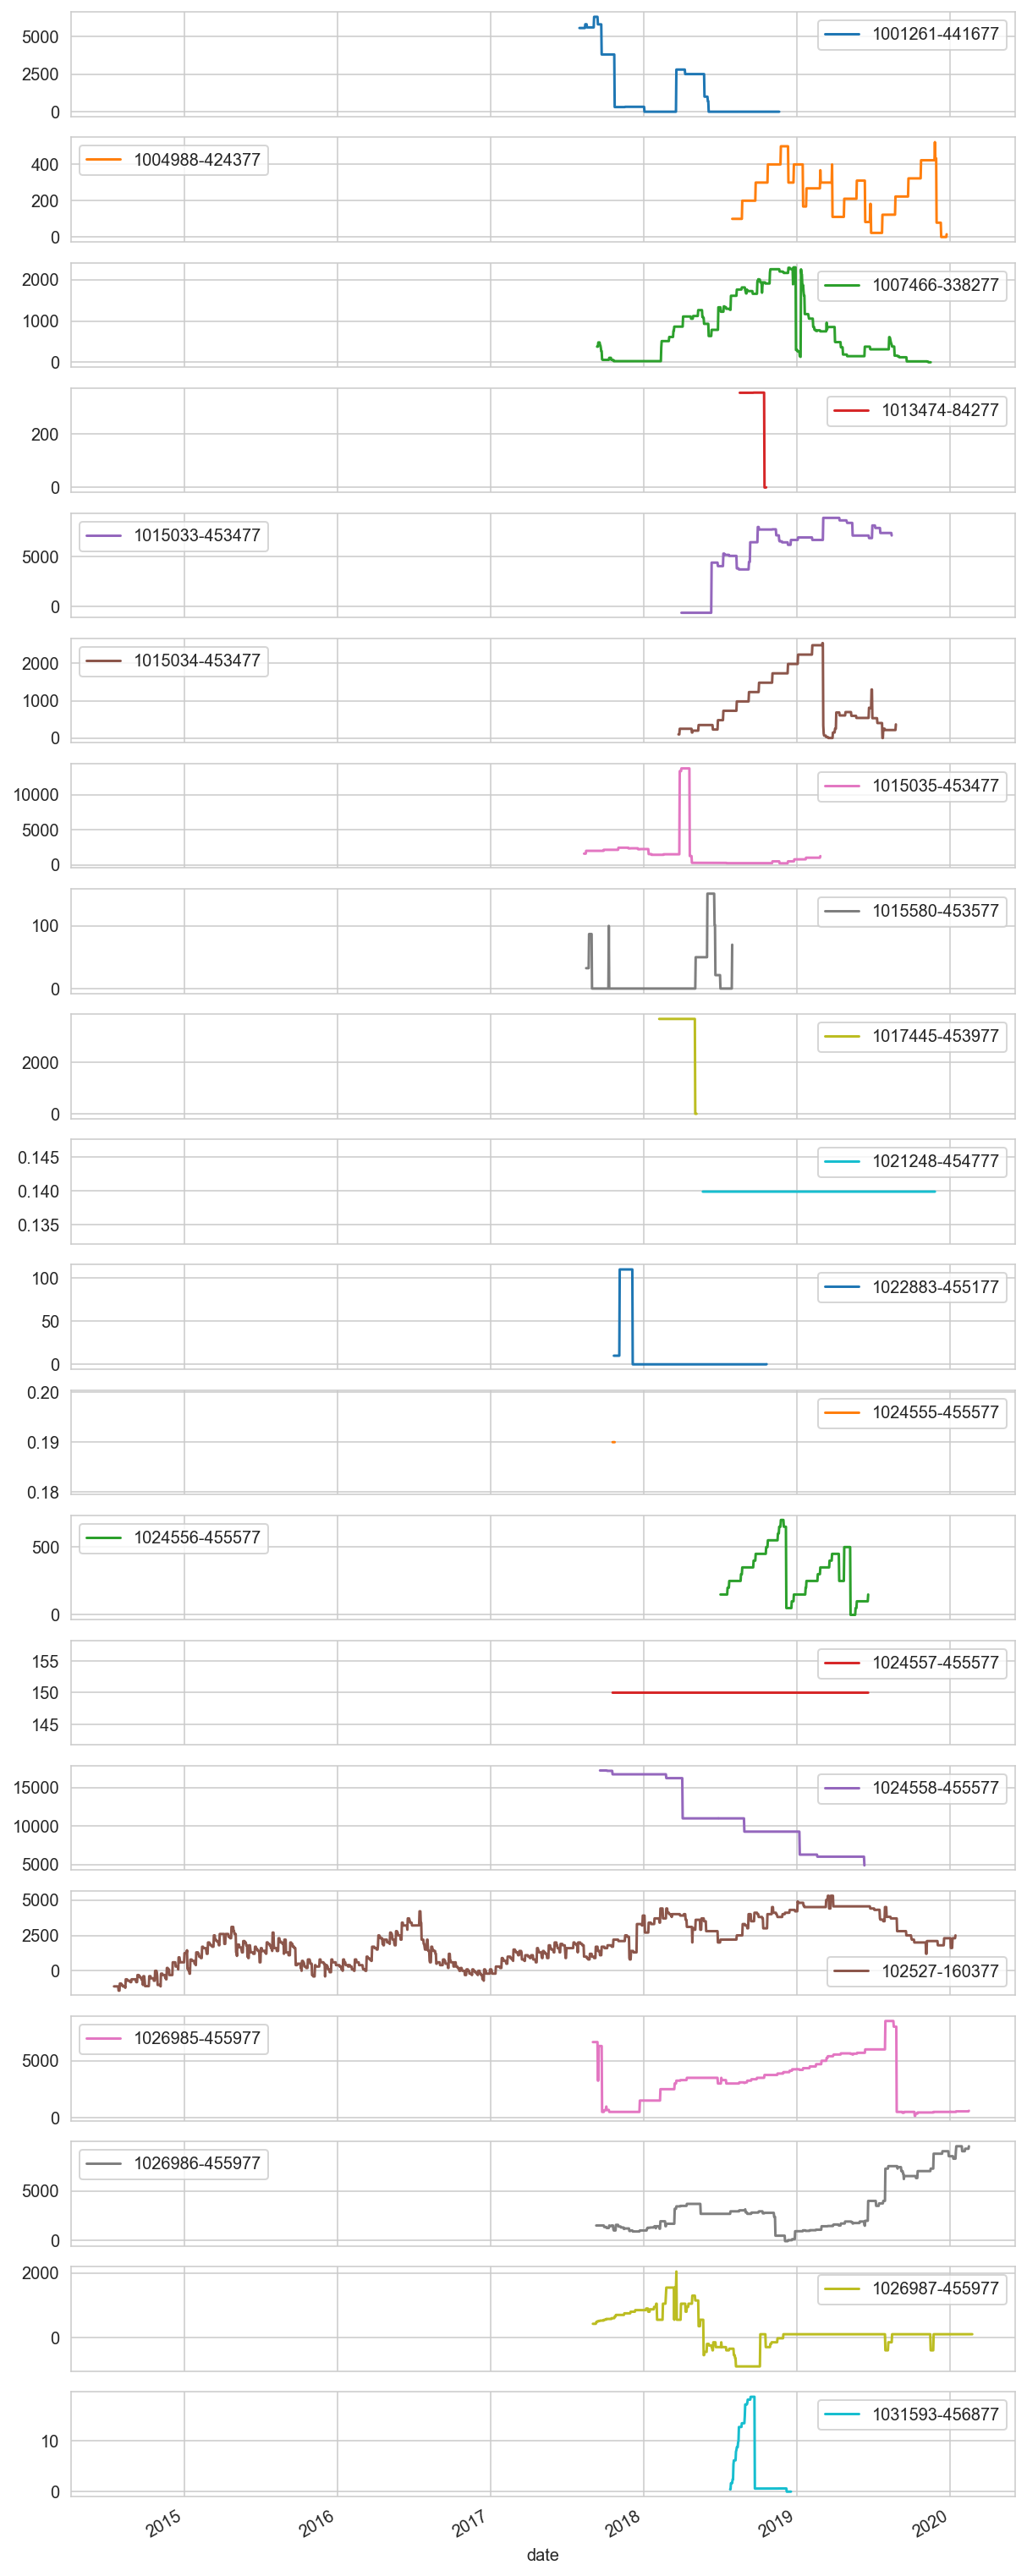

In [8]:
SAMPLE_SIZE = 20
savings_balances.pivot('date', 'account_label', 'balance').iloc[:, :SAMPLE_SIZE].plot(subplots=True, figsize=(10, 30));